Skip Gram Implementation

In [37]:
# importing libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

In [38]:
# checking if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [39]:
# training corpus
training_corpus = [
    "The quick brown fox jumps over the lazy dog.",
    "Natural language processing is a fascinating field.",
    "Machine learning algorithms can learn from data.",
    "Artificial intelligence is transforming many industries.",
    "Deep learning is a subset of machine learning.",
    "Neural networks are inspired by the human brain.",
    "Data scientists analyze large datasets to extract insights.",
    "Python is a popular programming language for data science.",
    "Text mining involves deriving meaningful information from text.",
    "Computers can understand human language through NLP.",
    "Big data technologies handle vast amounts of information.",
    "Cloud computing provides scalable resources on demand.",
    "The internet of things connects everyday devices to the internet.",
    "Robotics involves designing and programming robots.",
    "Augmented reality overlays digital content onto the real world.",
    "Virtual reality immerses users in a simulated environment.",
    "Blockchain technology secures digital transactions.",
    "Cybersecurity is essential to protect data and systems.",
    "Quantum computing promises to revolutionize computation.",
    "Bioinformatics combines biology and data science to understand biological data."
]

In [40]:
# data preprocessing
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def preprocess(corpus):
    # tokenising the text
    tokenized_data = word_tokenize(corpus) 

    # converting to lowercase and removing non-alphanumeric tokens
    processed_text = [word.lower() for word in tokenized_data if word.isalnum()]
    return processed_text

processed_corpus = [preprocess(sentence) for sentence in training_corpus]
print(processed_corpus)

[['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog'], ['natural', 'language', 'processing', 'is', 'a', 'fascinating', 'field'], ['machine', 'learning', 'algorithms', 'can', 'learn', 'from', 'data'], ['artificial', 'intelligence', 'is', 'transforming', 'many', 'industries'], ['deep', 'learning', 'is', 'a', 'subset', 'of', 'machine', 'learning'], ['neural', 'networks', 'are', 'inspired', 'by', 'the', 'human', 'brain'], ['data', 'scientists', 'analyze', 'large', 'datasets', 'to', 'extract', 'insights'], ['python', 'is', 'a', 'popular', 'programming', 'language', 'for', 'data', 'science'], ['text', 'mining', 'involves', 'deriving', 'meaningful', 'information', 'from', 'text'], ['computers', 'can', 'understand', 'human', 'language', 'through', 'nlp'], ['big', 'data', 'technologies', 'handle', 'vast', 'amounts', 'of', 'information'], ['cloud', 'computing', 'provides', 'scalable', 'resources', 'on', 'demand'], ['the', 'internet', 'of', 'things', 'connects', 'everyday', 'de

[nltk_data] Downloading package punkt to /home/rahul/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [41]:
# creating vocabulary
vocabulary = set(word for sentence in processed_corpus for word in sentence)
vocab_size = len(vocabulary)

# counting word frequencies
vocab_counter = Counter(word for sentence in processed_corpus for word in sentence)

# creating word frequency list
word_frequency = [vocab_counter[word] for word in vocabulary]

# creating word to index map
word2Index = {word:i for i,word in enumerate(vocabulary)}
print(word2Index)

{'essential': 0, 'everyday': 1, 'fox': 2, 'intelligence': 3, 'virtual': 4, 'processing': 5, 'in': 6, 'many': 7, 'to': 8, 'revolutionize': 9, 'biology': 10, 'human': 11, 'internet': 12, 'designing': 13, 'is': 14, 'text': 15, 'language': 16, 'computation': 17, 'quick': 18, 'brown': 19, 'natural': 20, 'environment': 21, 'python': 22, 'transforming': 23, 'learn': 24, 'augmented': 25, 'users': 26, 'connects': 27, 'big': 28, 'cloud': 29, 'can': 30, 'popular': 31, 'lazy': 32, 'robots': 33, 'combines': 34, 'data': 35, 'digital': 36, 'networks': 37, 'blockchain': 38, 'artificial': 39, 'by': 40, 'robotics': 41, 'world': 42, 'resources': 43, 'extract': 44, 'handle': 45, 'inspired': 46, 'of': 47, 'understand': 48, 'nlp': 49, 'devices': 50, 'programming': 51, 'vast': 52, 'transactions': 53, 'provides': 54, 'field': 55, 'technology': 56, 'demand': 57, 'content': 58, 'are': 59, 'onto': 60, 'through': 61, 'science': 62, 'meaningful': 63, 'mining': 64, 'promises': 65, 'overlays': 66, 'for': 67, 'and': 

In [42]:
# defining dataset class for Skip Gram
class SkipGramDataset(Dataset):
    def __init__(self, processed_corpus,word_frequency, word2Index, context_window, num_neg_samples):
        self.corpus = processed_corpus
        self.word2Index = word2Index
        self.context_window = context_window
        self.num_neg_samples = num_neg_samples
        self.word_frequency = word_frequency
        self.pos_samples = self.generate_positive_samples()

    def generate_positive_samples(self):
        pos_samples = set()
        for sentence in processed_corpus:
            for i,target_word in enumerate(sentence):
                samples = sentence[max(0,i-self.context_window):i] + sentence[i+1:min(i+self.context_window+1,len(sentence))]
                for sample in samples:
                    pos_samples.add((word2Index[target_word],word2Index[sample]))
        return list(pos_samples)
    
    def generate_negative_samples(self, target_word_idx):
        pos_samples = self.generate_positive_samples()
        vocab_size = len(self.word_frequency)

        # counting frequency 
        modified_word_frequency = np.array(self.word_frequency) ** 3/4
        word_probs = modified_word_frequency / np.sum(modified_word_frequency)

        negative_samples = set()

        while len(negative_samples) < self.num_neg_samples:
            negative_sample_idx = np.random.choice(vocab_size, p=word_probs)
            if negative_sample_idx != target_word_idx and (target_word_idx,negative_sample_idx) not in pos_samples:
                negative_samples.add(negative_sample_idx)
        
        return list(negative_samples)
    
    '''
    Purpose: Return a single sample from the dataset.
    Parameters: idx: An integer index to access a particular sample.
    Returns: The method should return the data sample at the specified index, 
        typically as a tuple containing inputs and targets (e.g., (input, target)).'''
    def __getitem__(self, idx):
        target_word_idx, context_word_idx = self.pos_samples[idx]
        negative_samples_idx = self.generate_negative_samples(target_word_idx)
        return target_word_idx, context_word_idx, torch.tensor(negative_samples_idx)
    
    '''
    Purpose: Return the total number of samples in the dataset.
    Parameters: None.
    Returns: An integer representing the total number of samples in the dataset.'''
    def __len__(self):
        return len(self.pos_samples)



In [43]:
# defining architecture for SkipGram model
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super(SkipGram,self).__init__() # calling the initializer of parent class of SkipGram (i.e. initializer of nn.Module)
        
        '''
        Purpose: Maps categorical data (e.g., word indices) to dense continuous vectors.
        Operation: Lookup operation.
        Parameters: Embedding matrix of size (vocab_size, embedding_dim).'''

        self.embedding_layer = nn.Embedding(vocab_size,embedding_size)

        '''
        Purpose: Applies a linear transformation to the input data.
        Operation: Matrix multiplication and addition.
        Parameters: Weight matrix of size (input_dim, output_dim) and bias vector of size (output_dim).'''

        self.linear_layer = nn.Linear(embedding_size,vocab_size)

    
    def forward(self, target_word_idx):
        # embedding of the input word
        embedding = self.embedding_layer(target_word_idx)

        # applying linear transformation to the embedding
        output = self.linear_layer(embedding)

        return output


In [44]:
# Hyperparameters
context_window = 2
num_neg_samples = 5
learning_rate = 0.02
embedding_size = 100
num_epochs = 500
batch_size = 8

In [45]:
# create dataset and dataloader
corpus_dataset = SkipGramDataset(processed_corpus,word_frequency, word2Index, context_window, num_neg_samples)
corpus_dataloader = DataLoader(corpus_dataset, batch_size=batch_size, shuffle=True)

# sample batch
for data in corpus_dataloader:
    print(data)
    break

[tensor([ 58, 104,  23,  99,  16,  84,  87,  64]), tensor([91, 15, 14, 63, 14, 42, 81, 15]), tensor([[ 35,   8,  14,  15,  47],
        [ 35,  68, 101,  14,  91],
        [ 35, 101,   8,  12,  91],
        [ 36,   8,  14,  51,  91],
        [101,   8,  42,  87,  91],
        [ 35,   8,  12,  14,  16],
        [ 35, 101,   8,  14,  91],
        [  2,  35,  14,  47,  91]])]


In [46]:
# defining model, loss criteria and optimizer
model = SkipGram(vocab_size,embedding_size)
model.to(device)
# loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [47]:
# Custom loss function for negative sampling
def negative_sampling_loss(pos_scores, neg_scores):
    # Positive loss (maximize log(sigmoid(pos_scores)))
    pos_loss = -torch.log(torch.sigmoid(pos_scores)).mean()
    # Negative loss (minimize log(sigmoid(-neg_scores)))
    neg_loss = -torch.log(torch.sigmoid(-neg_scores)).mean()
    return pos_loss + neg_loss

In [48]:
# training loop

for epoch in range(num_epochs):
    total_loss = 0.0
    for target_word_idx, context_word_idx, negative_samples_idx in corpus_dataloader:
        optimizer.zero_grad()
        target_word_idx, context_word_idx, negative_samples_idx = target_word_idx.to(device), context_word_idx.to(device), negative_samples_idx.to(device)

        # Positive examples
        pos_scores = model(target_word_idx).gather(1, context_word_idx.view(-1, 1)).squeeze()
        
        # Negative examples
        neg_scores = model(target_word_idx).gather(1, negative_samples_idx)
        
        # Compute custom negative sampling loss
        loss = negative_sampling_loss(pos_scores, neg_scores)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch: {epoch+1} total loss:{total_loss/len(corpus_dataloader)}")
        

Epoch: 1 total loss:1.454644637029679
Epoch: 2 total loss:0.39431355380621114
Epoch: 3 total loss:0.24822961636742608
Epoch: 4 total loss:0.1803410189440016
Epoch: 5 total loss:0.139614911383537
Epoch: 6 total loss:0.10501236358626945
Epoch: 7 total loss:0.07775432613418727
Epoch: 8 total loss:0.04509425775499129
Epoch: 9 total loss:0.03780929483167949
Epoch: 10 total loss:0.032761558172766304
Epoch: 11 total loss:0.024550521112673106
Epoch: 12 total loss:0.021268076385508795
Epoch: 13 total loss:0.01576348775845082
Epoch: 14 total loss:0.01555387520032828
Epoch: 15 total loss:0.013276125945639415
Epoch: 16 total loss:0.013819212933666393
Epoch: 17 total loss:0.01044063801022216
Epoch: 18 total loss:0.009501726416199178
Epoch: 19 total loss:0.007467618173934886
Epoch: 20 total loss:0.007472942625248774
Epoch: 21 total loss:0.015256309370342338
Epoch: 22 total loss:0.008603829325589
Epoch: 23 total loss:0.007424128867807935
Epoch: 24 total loss:0.0054669746018366
Epoch: 25 total loss:0.

In [49]:
# extract the embeddings
def get_word_embedding(word):
    word_idx = word2Index(word)
    word_idx_tensor = torch.tensor([word_idx]).to(device)
    word_embedding = model.embedding_layer(word_idx_tensor)
    return word_embedding.cpu().detach().numpy()

# Retrieve embeddings for all words
word_embeddings = model.embedding_layer.weight.cpu().detach().numpy()

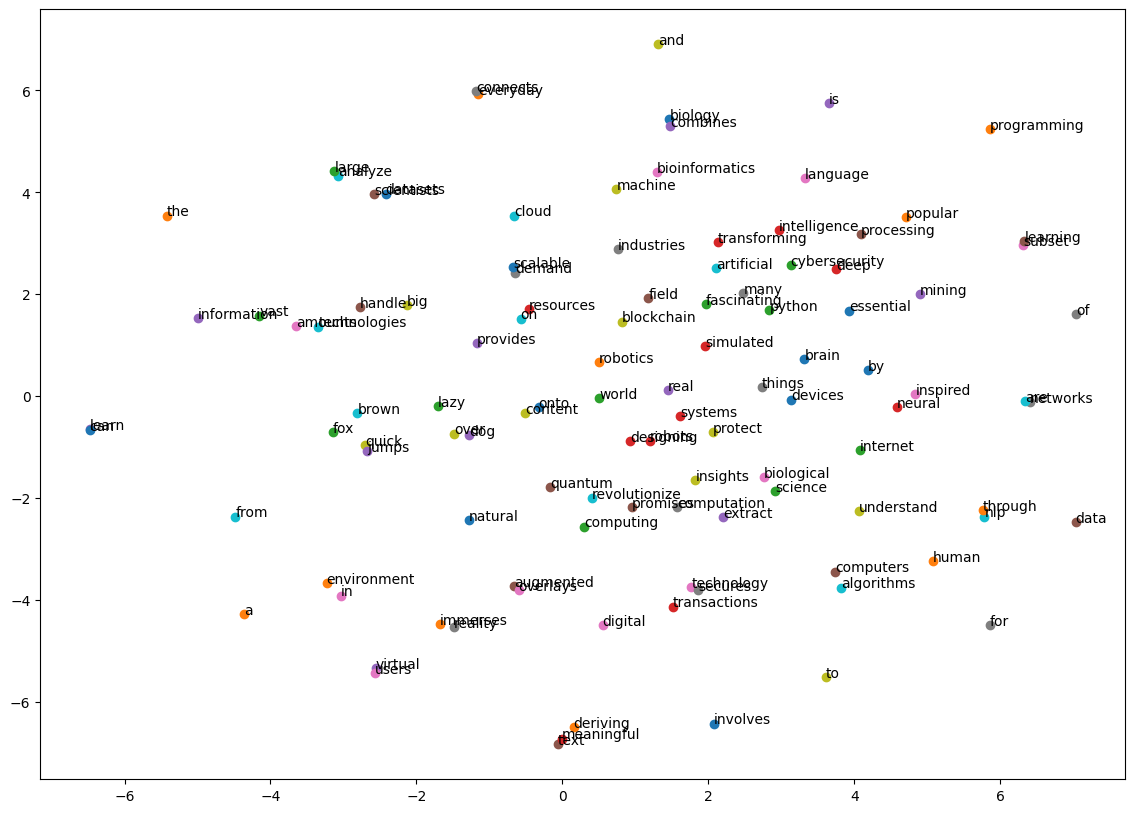

In [51]:
# plot the embedding using t-SNE
tsne = TSNE(n_components=2,random_state=3)

embedding_2d = tsne.fit_transform(word_embeddings)

plt.figure(figsize=(14,10))
for i,word in enumerate(vocabulary):
    plt.scatter(embedding_2d[i,0], embedding_2d[i,1])
    plt.annotate(word,xy=(embedding_2d[i,0], embedding_2d[i,1]))

plt.show()